In [ ]:
# Download dependencies
!pip install imgaug
!apt-get update && apt-get install -y python3-opencv
!pip install keras-flops

# Import libraries
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.utils.layer_utils import count_params
from keras_flops import get_flops
import sys
import os
import random
from imgaug import augmenters as iaa

# function: print train and val loss and accuracy 
def print_graphs(history_record):
    print(history_record.history.keys())
    # summarize history for accuracy
    plt.plot(history_record.history['accuracy'])
    plt.plot(history_record.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
  
    # summarize history for loss
    plt.plot(history_record.history['loss'])
    plt.plot(history_record.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

# function: gradcam visualization on GHOSTFACE's attention
def plot_gradcam(index_img, model):
    
    emotion_dict = {0:"Surprise", 1:"Fear", 2: "Disgusted", 3: "Happiness", 4: "Sadness", 5: "Anger", 6: "Neutral"}
    
    # Plot test images
    image = X_test[index_img]
    
    # output of last convolution layer
    last_conv_layer_name = 'block162_conv_1'
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

    # create model that takes the output of the model above, uses the remaining layers to get final predictions
    classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input

    #     TO DO: ADD LAYERS GLOBAL AVERAGE POOLING AND DENSE LAYER
    for layer_name in ["global_average_pooling", "fc1", "classifier"]:
        x = model.get_layer(layer_name)(x)
    classifier_model = tf.keras.Model(classifier_input, x)

    with tf.GradientTape() as tape:
        inputs = image[np.newaxis, ...]
        last_conv_layer_output = last_conv_layer_model(inputs)
        tape.watch(last_conv_layer_output)
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    grads = tape.gradient(top_class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    gradcam = np.mean(last_conv_layer_output, axis=-1)
    gradcam = np.clip(gradcam, 0, np.max(gradcam)) / np.max(gradcam)
    gradcam = cv2.resize(gradcam, (224, 224))

    plt.figure(figsize=(7, 7))
    
    ax = plt.subplot(1, 2, 1)
    plt.imshow(image.astype('uint8'))
    plt.axis('off')
    plt.title('Original Image: {}'.format(emotion_dict[np.argmax(Y_test[index_img])]))
    
    ax = plt.subplot(1, 2, 2)
    plt.imshow(image.astype('uint8'))
    plt.imshow(gradcam, alpha=0.5)
    plt.axis('off')
    plt.title('Predicted: {}'.format(emotion_dict[np.argmax(model.predict(X_test[index_img][tf.newaxis, ...]))]))
    plt.tight_layout()
    plt.show()

In [ ]:
# Import RAF-DB data set
X_train = np.load('rafdb/X_train_rafdb.npy')
Y_train = np.load('rafdb/Y_train_rafdb.npy')
X_dev = np.load('rafdb/X_val_rafdb.npy')
Y_dev = np.load('rafdb/Y_val_rafdb.npy')
X_test = np.load('rafdb/X_test_rafdb.npy')
Y_test = np.load('rafdb/Y_test_rafdb.npy')

print(X_train.shape, Y_train.shape)
print(X_dev.shape, Y_dev.shape)
print(X_test.shape, Y_test.shape)

(11043, 224, 224, 3) (11043, 7)
(1228, 224, 224, 3) (1228, 7)
(3068, 224, 224, 3) (3068, 7)


In [4]:
# Triplet Attention Module
def TripletAttention(x, block_code):

    permute_hw = tf.keras.layers.Permute((1, 2, 3))(x)
    concat_hw = tf.keras.layers.Concatenate(axis=-1)([tf.expand_dims(tf.math.reduce_max(permute_hw, axis=-1), axis=-1), tf.expand_dims(tf.math.reduce_mean(permute_hw, axis=-1), axis=-1)])
    conv_hw = tf.keras.layers.Conv2D(filters=1, kernel_size=7, strides=1, padding='same', data_format='channels_last')(concat_hw)
    batchnorm_hw = tf.keras.layers.BatchNormalization()(conv_hw)
    sig_act_hw = tf.keras.layers.Activation('sigmoid')(batchnorm_hw)
    skipconn_hw = tf.keras.layers.Multiply()([sig_act_hw, permute_hw])

    permute_w = tf.keras.layers.Permute((1, 3, 2))(x)
    concat_w = tf.keras.layers.Concatenate(axis=-1)([tf.expand_dims(tf.math.reduce_max(permute_w, axis=-1), axis=-1), tf.expand_dims(tf.math.reduce_mean(permute_w, axis=-1), axis=-1)])
    conv_w = tf.keras.layers.Conv2D(filters=1, kernel_size=7, strides=1, padding='same', data_format='channels_last')(concat_w)
    batchnorm_w = tf.keras.layers.BatchNormalization()(conv_w)
    sig_act_w = tf.keras.layers.Activation('sigmoid')(batchnorm_w)
    skipconn_w = tf.keras.layers.Multiply()([sig_act_w, permute_w])
    repermute_w = tf.keras.layers.Permute((1, 3, 2))(skipconn_w)

    permute_h = tf.keras.layers.Permute((3, 1, 2), name= 'block' + str(block_code) + '_permute1_h')(x)
    concat_h = tf.keras.layers.Concatenate(axis=-1, name= 'block' + str(block_code) + '_concat_h')([tf.expand_dims(tf.math.reduce_max(permute_h, axis=-1), axis=-1), tf.expand_dims(tf.math.reduce_mean(permute_h, axis=-1), axis=-1)])
    conv_h = tf.keras.layers.Conv2D(filters=1, kernel_size=7, strides=1, padding='same', data_format='channels_last', name= 'block' + str(block_code) + '_conv_h')(concat_h)
    batchnorm_h = tf.keras.layers.BatchNormalization(name= 'block' + str(block_code) + '_batchnorm_h')(conv_h)
    sig_act_h = tf.keras.layers.Activation('sigmoid', name= 'block' + str(block_code) + '_sigmoid_h')(batchnorm_h)
    skipconn_h = tf.keras.layers.Multiply(name= 'block' + str(block_code) + '_mult_h')([sig_act_h, permute_h])
    repermute_h = tf.keras.layers.Permute((3, 2, 1), name= 'block' + str(block_code) + '_permute2_h')(skipconn_h)

    average_lyr = tf.keras.layers.Average(name='block' + str(block_code) + '_average')([skipconn_hw, repermute_w, repermute_h])
    return average_lyr

# Fused MB-Convolution Module
def fused_conv(x, block_num, filters, strides, attention=False):
    x1 = layers.Conv2D(filters=filters, kernel_size=3, strides=strides, padding='same', use_bias=False, name='block'+str(block_num)+'_conv_1')(x)
    x1 = layers.BatchNormalization(name='block'+str(block_num)+'_batchnorm_1')(x1)
    x1 = layers.Activation('relu', name='block'+str(block_num)+'_relu_1')(x1)
    
    if attention == True:
        x1 = TripletAttention(x1, block_num)

    x2 = layers.Conv2D(filters=filters, kernel_size=strides, strides=strides, padding='same', use_bias=False, name='block'+str(block_num)+'_conv_2')(x1)
    x2 = layers.BatchNormalization(name='block'+str(block_num)+'_batchnorm_2')(x2)

    if strides!=2:
        x3 = layers.Add(name='block'+str(block_num)+'_add')([x, x2])
    else:
        x3 = x2
        
    return x3

# Ghost Module
def ghostnet_module(x, block_num, filters, kernel_size, strides=1, activation=True):
    x1 = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=1, padding='same', use_bias=False, name='block'+str(block_num)+'_conv_1')(x)
    x1 = layers.BatchNormalization(name='block'+str(block_num)+'_batchnorm_1')(x1)
    x1 = layers.Activation('relu', name='block'+str(block_num)+'_relu1')(x1)
    
    x2 = layers.DepthwiseConv2D(kernel_size=kernel_size, strides=strides, padding='same', use_bias=False, name='block'+str(block_num)+'_dwconv_1')(x1)
    x2 = layers.BatchNormalization(name='block'+str(block_num)+'_batchnorm_2')(x2)
    if activation==True:
        x2 = layers.Activation('relu', name='block'+str(block_num)+'_relu2')(x2)
    
    x3 = layers.Add(name='block'+str(block_num)+'_add')([x1, x2])
    return x3

# Attention GhostNet Bottleneck Module
def ghostnet_bottleneck(x, block_num, filters, strides, kernel_size=3):
          
    x1 = ghostnet_module(x, str(block_num) + '1', filters, kernel_size, strides=1, activation=True)
    x1 = layers.BatchNormalization(name='block'+str(block_num)+'_batchnorm_1')(x1)
    x1 = layers.Activation('relu', name='block'+str(block_num)+'_relu_1')(x1)
    
    x1 = TripletAttention(x1, block_num)
    
    x2 = ghostnet_module(x1, str(block_num) + '2', filters, kernel_size, strides=1, activation=False)
    x2 = layers.BatchNormalization(name='block'+str(block_num)+'_batchnorm_2')(x2)
    
    b0, h0, w0, c0 = x2.shape 
    if strides>1:
        if c0!=filters*2:
            x = layers.DepthwiseConv2D(kernel_size=1, strides=1, padding='same', use_bias=False, name='block'+str(block_num)+'_downsample_dwconv_correction')(x)
            x = layers.Conv2D(filters=filters, kernel_size=1, strides=1, padding='same', use_bias=False, name='block'+str(block_num)+'_downsample_conv_correction')(x)
        
        x3 = layers.Add(name='block'+str(block_num)+'_add')([x, x2])
        x3 = layers.DepthwiseConv2D(kernel_size=kernel_size, strides=2, padding='same', use_bias=False, name='block'+str(block_num)+'_downsample_dwconv1')(x3)
    else:
        x3 = layers.Add(name='block'+str(block_num)+'_add')([x, x2])

    return x3

# GHOSTFACE CLASSIFICATION MODEL 
def classification_model(input_shape=(224, 224, 3)):
    input_lyr = tf.keras.layers.Input(input_shape)
    
    norm = normalizer(input_lyr)
    
    x = layers.Conv2D(filters=8, kernel_size=5, strides=2, padding='same', use_bias=False, name='normal_conv_1')(norm)
    x = layers.BatchNormalization(name='normal_bn_1')(x)
    x = layers.Activation('relu', name='normal_relu')(x)
    
    x = fused_conv(x=x, block_num=1, filters=8, strides=1)
    x = fused_conv(x=x, block_num=2, filters=8, strides=1)
    x = fused_conv(x=x, block_num=3, filters=8, strides=1, attention=True)
    
    x = fused_conv(x=x, block_num=4, filters=16, strides=2, attention=True)
    x = fused_conv(x=x, block_num=5, filters=16, strides=1)
    x = fused_conv(x=x, block_num=6, filters=16, strides=1, attention=True)
    
    x = ghostnet_bottleneck(x=x, block_num=7, filters=16, kernel_size=3, strides=2)
    x = ghostnet_bottleneck(x=x, block_num=8, filters=16, kernel_size=3, strides=1)
    x = ghostnet_bottleneck(x=x, block_num=9, filters=16, kernel_size=3, strides=1)
    x = ghostnet_bottleneck(x=x, block_num=10, filters=16, kernel_size=3, strides=1)
    
    x = ghostnet_bottleneck(x=x, block_num=11, filters=32, kernel_size=3, strides=2)
    x = ghostnet_bottleneck(x=x, block_num=12, filters=32, kernel_size=3, strides=1)
    x = ghostnet_bottleneck(x=x, block_num=13, filters=32, kernel_size=3, strides=1)
    
    x = ghostnet_bottleneck(x=x, block_num=14, filters=64, kernel_size=3, strides=2)
    x = ghostnet_bottleneck(x=x, block_num=15, filters=128, kernel_size=3, strides=2)
    x = ghostnet_bottleneck(x=x, block_num=16, filters=240, kernel_size=3, strides=2)
    
    # Classifier
    gap = layers.GlobalAveragePooling2D(name='global_average_pooling')(x)
    dense_layer_1 = layers.Dense(240, name='fc1')(gap)
    emotion_classifier = layers.Dense(7, name='classifier')(dense_layer_1)
    model = tf.keras.Model(inputs=input_lyr, outputs = emotion_classifier)
    return model

In [ ]:
normalizer = tf.keras.layers.Normalization(axis=None)
normalizer.adapt(X_train)

2022-06-05 07:41:05.995089: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-05 07:41:06.046627: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-05 07:41:06.047056: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-05 07:41:06.049397: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-05 07:41:06.049834: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read f

In [7]:
get_flops(classification_model())/10**6 # MFLOPS

134.655852

In [8]:
count_params(classification_model().weights) # total params

1285619

In [9]:
count_params(classification_model().trainable_weights) # trainable params

1278130

In [ ]:
datagen_train = ImageDataGenerator(rotation_range=25, horizontal_flip=True, 
                                   width_shift_range=0.25, height_shift_range=0.25)
datagen_train.fit(X_train)

In [ ]:
# Training without MixUp, RandAug

batch_size = 16
epochs = 100
learning_rate = 0.1
checkpoint_filepath = 'baseline_nodp/chckpt.ckpt'

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, clipnorm=1.)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction=tf.losses.Reduction.NONE)

model = classification_model()
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
save_weights = tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath, monitor="val_loss", mode='min', save_best_only=True, save_weights_only=True)
reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5, patience=5, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, mode='min', restore_best_weights=True)

history = model.fit(datagen_train.flow(X_train, Y_train, batch_size=batch_size), epochs=epochs, validation_data=(X_dev, Y_dev), callbacks=[save_weights, reduce_learning_rate, early_stopping])

Epoch 1/100
691/691 [==============================] - ETA: 0s - loss: 1.6620 - accuracy: 0.3782

2022-06-05 07:52:39.149868: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 739393536 exceeds 10% of free system memory.
2022-06-05 07:52:39.878967: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 739393536 exceeds 10% of free system memory.


691/691 [==============================] - 146s 173ms/step - loss: 1.6620 - accuracy: 0.3782 - val_loss: 1.6427 - val_accuracy: 0.3884 - lr: 0.1000
Epoch 2/100
691/691 [==============================] - 114s 166ms/step - loss: 1.6386 - accuracy: 0.3854 - val_loss: 1.6255 - val_accuracy: 0.3827 - lr: 0.1000
Epoch 3/100
691/691 [==============================] - 114s 166ms/step - loss: 1.6340 - accuracy: 0.3869 - val_loss: 1.6176 - val_accuracy: 0.3950 - lr: 0.1000
Epoch 4/100
691/691 [==============================] - 112s 162ms/step - loss: 1.6329 - accuracy: 0.3855 - val_loss: 1.6282 - val_accuracy: 0.3941 - lr: 0.1000
Epoch 5/100
691/691 [==============================] - 112s 162ms/step - loss: 1.6278 - accuracy: 0.3882 - val_loss: 1.6260 - val_accuracy: 0.3893 - lr: 0.1000
Epoch 6/100
691/691 [==============================] - 112s 162ms/step - loss: 1.6295 - accuracy: 0.3872 - val_loss: 1.6329 - val_accuracy: 0.3958 - lr: 0.1000
Epoch 7/100
691/691 [==============================]

In [ ]:
loss, accuracy = model.evaluate(X_test, Y_test)
print('model loss: {}%'.format(loss))
print('model accuracy: {}%'.format(accuracy))

2022-06-05 11:09:41.177491: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1847279616 exceeds 10% of free system memory.


96/96 [==============================] - 3s 34ms/step - loss: 0.6740 - accuracy: 0.7797
model loss: 0.6740125417709351%
model accuracy: 0.7796609997749329%


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


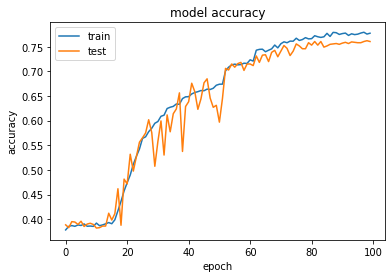

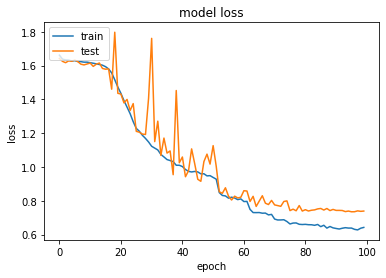

In [ ]:
print_graphs(history)

In [ ]:
# function: RandAug
def rand_augmentation(X_train_kaug, Y_train_kaug):
    print(X_train_kaug.shape, Y_train_kaug.shape)
    rand_aug = iaa.RandAugment(n=(0, 3), m=(2, 4))
    X_train_kaug = rand_aug(images=X_train_kaug.astype('uint8')).astype('float32')
    print(X_train_kaug.dtype, Y_train_kaug.dtype)
    return X_train_kaug, Y_train_kaug

X_train, Y_train = rand_augmentation(X_train, Y_train)

(11043, 224, 224, 3) (11043, 7)
float32 float32


In [ ]:
# Training with RandAug
batch_size = 16
epochs = 100
learning_rate = 0.1
checkpoint_filepath = 'baseline_randaug_nodp/chckpt.ckpt'

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, clipnorm=1.)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction=tf.losses.Reduction.NONE)

model = classification_model()
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
save_weights = tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath, monitor="val_loss", mode='min', save_best_only=True, save_weights_only=True)
reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5, patience=5, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, mode='min', restore_best_weights=True)

history = model.fit(datagen_train.flow(X_train, Y_train, batch_size=batch_size), epochs=epochs, validation_data=(X_dev, Y_dev), callbacks=[save_weights, reduce_learning_rate, early_stopping])

Epoch 1/100


2022-06-05 14:02:11.589024: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


691/691 [==============================] - 133s 153ms/step - loss: 1.6670 - accuracy: 0.3814 - val_loss: 1.6564 - val_accuracy: 0.3884 - lr: 0.1000
Epoch 2/100
691/691 [==============================] - 104s 150ms/step - loss: 1.6470 - accuracy: 0.3857 - val_loss: 1.6375 - val_accuracy: 0.3884 - lr: 0.1000
Epoch 3/100
691/691 [==============================] - 101s 146ms/step - loss: 1.6406 - accuracy: 0.3856 - val_loss: 1.6296 - val_accuracy: 0.3795 - lr: 0.1000
Epoch 4/100
691/691 [==============================] - 100s 145ms/step - loss: 1.6372 - accuracy: 0.3872 - val_loss: 1.6209 - val_accuracy: 0.3844 - lr: 0.1000
Epoch 5/100
691/691 [==============================] - 99s 143ms/step - loss: 1.6326 - accuracy: 0.3858 - val_loss: 1.6911 - val_accuracy: 0.3893 - lr: 0.1000
Epoch 6/100
691/691 [==============================] - 101s 147ms/step - loss: 1.6333 - accuracy: 0.3849 - val_loss: 1.6150 - val_accuracy: 0.3901 - lr: 0.1000
Epoch 7/100
691/691 [==============================] 

In [ ]:
loss, accuracy = model.evaluate(X_test, Y_test)
print('model loss: {}%'.format(loss))
print('model accuracy: {}%'.format(accuracy))

2022-06-05 16:55:50.926062: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1847279616 exceeds 10% of free system memory.
2022-06-05 16:55:53.233502: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1847279616 exceeds 10% of free system memory.


96/96 [==============================] - 3s 31ms/step - loss: 0.6697 - accuracy: 0.7722
model loss: 0.6696911454200745%
model accuracy: 0.7721642851829529%


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


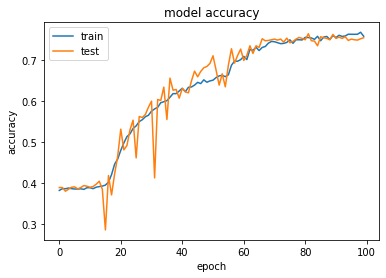

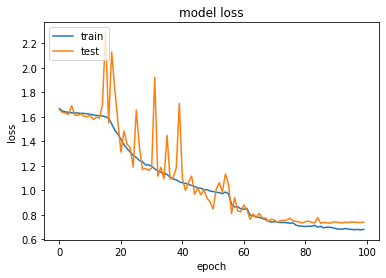

In [ ]:
print_graphs(history)